In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import xarray as xr

import sys
sys.path.insert(0, '../lib')
sys.path.insert(0, '../src')

import Utilities as util


In [2]:
loc_model1 = '../mod/model1/'
T_total_data = pd.read_csv(loc_model1 + 'expl_transition_ctypes.csv', index_col = 0)
T_data = T_total_data#.iloc[:-1]

classes = {str(k) + '.0':v for k, v in util.ISCCP_classes.items()}
T_data = T_data.rename(
            columns = classes, 
             index = classes
            ).drop(['invalid pixel'], axis = 1).drop(['invalid pixel'])
T_data = T_data.style.background_gradient(cmap=plt.cm.Blues).format('{:.2f}')


# html = T_data.render()
# import imgkit
# imgkit.from_string(html, '../fig/model0/transition.png')
# # html


import dataframe_image as dfi

df = pd.DataFrame(np.random.rand(6,4))
df_styled = df.style.background_gradient()

dfi.export(T_data, '../fig/model0/transition.png')

In [7]:
dir(T_data.index)

NameError: name 'd' is not defined

In [4]:
M = np.array(T_total_data)
M[:, 1] = M[:, 0] + M[:, 1] ## add probability on invalid pixel to clear sky. 

M = M[1:-1, 1:] # delete the rows for invalid pixel, and 'All'

In [4]:
def MC(x0, M, n):
    """
    Markov chain realization. 
    Takes 
        x0 (int) initial state in {0, ....,N-1}
        M (NXN- array) transition probability matrix
        n (int) number of iterations
    """
    
    x = np.zeros(n + 1, dtype = int)
    x[0] = x0
    
    N = M.shape[0]
    
    for i in range(n):
        x_prev = x[i]
        
        x_next = np.random.choice(N, p = M[x_prev])
#         print(x_next)
        x[i + 1] = int(x_next)
        
    return x

x = MC(1, M , 10000)

In [5]:
np.bincount(x) / len(x)

MC(1, M, 1)


array([1, 1])

### Run simulation from original image

In [6]:
loc_clean_data = '../data/clean_data/'
import pickle
from datetime import datetime 
with open(loc_clean_data + 'clean_dates.txt', 'rb') as f:
    dates = pickle.load(f)

# print(dates)
date = dates.date

start_date = datetime.strptime('10-12-2020', '%d-%m-%Y')
end_date = datetime.strptime('11-12-2020', '%d-%m-%Y')
idx = (start_date < date)  & (date < end_date) 

dates = dates[idx]

file = dates.file_name.loc[0]
images = xr.open_dataset(file)
images

# Only keep points which are in the right area and do contain a wind speed
dss = []
for file in dates.file_name:
    images = xr.open_dataset(file)
    dss.append(images)

images = xr.concat(dss, 't')

invalid =np.sum(images.ct == 0, axis = (1,2))
images = images.where(invalid < 10000, drop = True)

images = images.rename(dict(x = 'i', y = 'j'))
images = images.rename(dict(cth = 'h', cod = 'd'))

# images['i'] = range(len(images.i))
# images['j'] = range(len(images.j))
images['d'] = np.log(images.d)
images['z'] = (['t', 'i', 'j'], np.select([images.ct == 1, (images.ct > 1) & (~np.isnan(images.d)) & (~np.isnan(images.h))], [1, 0], 1))
# images['z_cloud'] = images.z.where(~np.isnan(images.d) & ~np.isnan(images.h))

images['d'] = images.d.where(images.z == 0)
images['h'] = images.h.where(images.z == 0)

In [7]:
util.ISCCP_classes.values()

dict_values(['invalid pixel', 'clear sky', 'cumulus', 'altocumulus', 'cirrus', 'stratocumulus', 'altostratus', 'cirrostratus', 'stratus', 'nimbostratus', 'deep convection'])

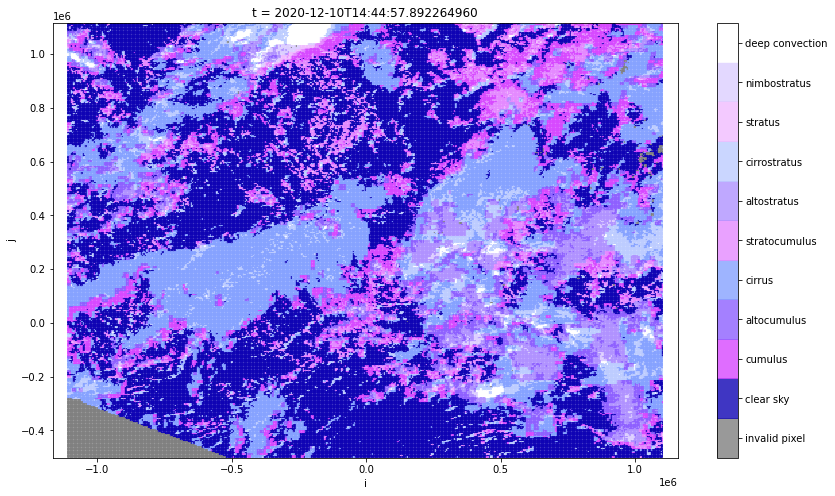

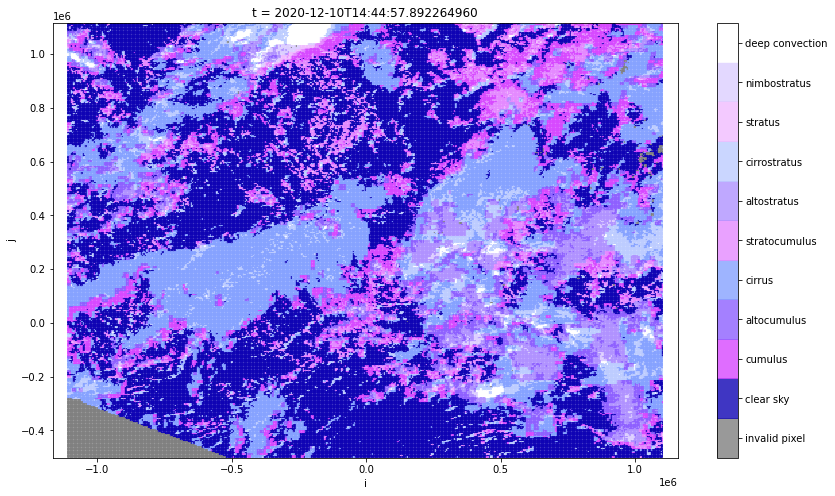

In [8]:

cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in np.linspace(0, 1, 11)]

# force the first color entry to be grey
cmaplist[0] = (.5, 0.5, .5, .8)
cmaplist[1] = (13/255, 0/255, 181/255, .8)

cmaplist[2] = (215/255, 73/255, 255/255, .8)
cmaplist[3] = (141/255, 96/255, 255/255, .8)
cmaplist[4] = (134/255, 162/255, 255/255, .8)

cmaplist[5] = (229/255, 138/255, 255/255, .8)
cmaplist[6] = (176/255, 146/255, 255/255, .8)
cmaplist[7] = (188/255, 204/255, 255/255, .8)

cmaplist[8] = (240/255, 188/255, 255/255, .8)
cmaplist[9] = (220/255, 206/255, 255/255, .8)
cmaplist[10] = (1, 1, 1, .8)

# create the new map
cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist)

# define the bins and normalize
bounds = np.linspace(-.5, 10.5, 12)
norm = mpl.colors.BoundaryNorm(bounds, 11)

levels = np.arange(11)


def plotCT(image):

    fig, ax = plt.subplots(figsize = (14, 8))
    im = image.astype(int).where(
        image >= 0, 0).plot(x = 'i', y = 'j',
                                                    cmap = cmap,
                                                    norm = norm,
                                                    add_colorbar = False,
                                                      )
    cbar = fig.colorbar(im, ticks = levels)
    cbar.ax.set_yticklabels(util.ISCCP_classes.values())                                                  
    plt.axis('equal')
    plt.show()
    return fig

image =  images.sel(t = images.t[20], j = slice(-500000))
image['z'] = image.z.astype(bool)
image['h'] = image.h.where(~image.z, -1)
image['d'] = image.d.where(~image.z, 0)
image.to_netcdf('../data/start_image0.nc')


plotCT(image.ct)


In [9]:
image.h


<xarray.DataArray 'h' (i: 441, j: 322)>
array([[ 3.5605063e+03,  2.3424385e+03,  2.3424385e+03, ...,
        -1.0000000e+00, -1.0000000e+00, -1.0000000e+00],
       [ 3.5605063e+03,  2.3424385e+03,  2.3424385e+03, ...,
        -1.0000000e+00, -1.0000000e+00, -1.0000000e+00],
       [ 1.1511674e+04,  1.0457500e+04,  1.0457500e+04, ...,
        -1.0000000e+00, -1.0000000e+00, -1.0000000e+00],
       ...,
       [-1.0000000e+00, -1.0000000e+00,  7.1051422e+02, ...,
        -1.0000000e+00, -1.0000000e+00, -1.0000000e+00],
       [-1.0000000e+00, -1.0000000e+00, -1.0000000e+00, ...,
        -1.0000000e+00, -1.0000000e+00, -1.0000000e+00],
       [-1.0000000e+00, -1.0000000e+00, -1.0000000e+00, ...,
        -1.0000000e+00, -1.0000000e+00, -1.0000000e+00]], dtype=float32)
Coordinates:
  * i        (i) float64 1.1e+06 1.095e+06 1.09e+06 ... -1.104e+06 -1.109e+06
  * j        (j) float64 1.113e+06 1.108e+06 1.103e+06 ... -4.94e+05 -4.99e+05
    t        datetime64[ns] 2020-12-10T14:44:57.892264960

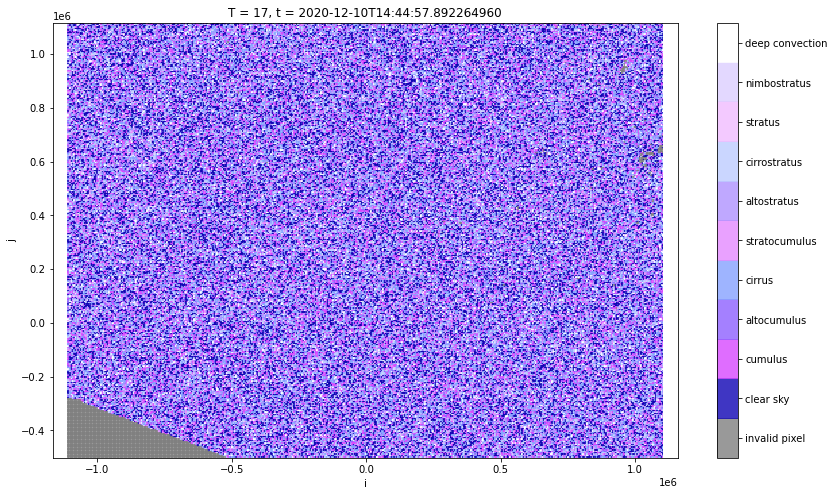

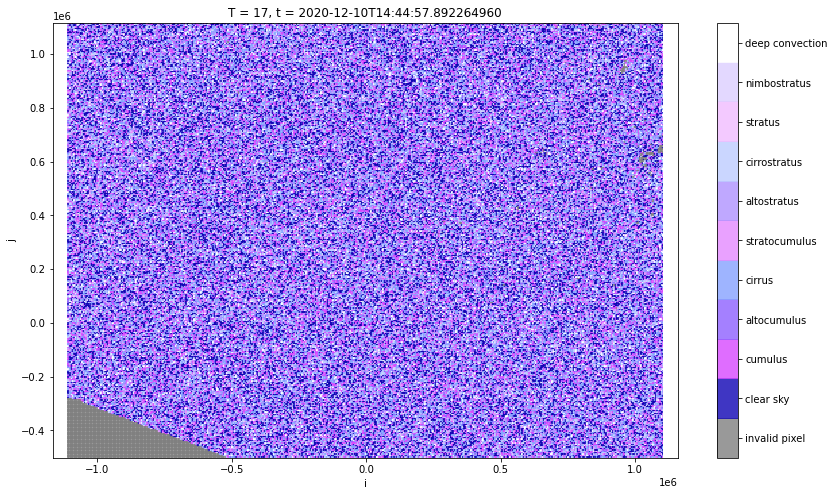

In [19]:
X0 = image.ct

import itertools

n = 18 # 3 hour
X = X0.expand_dims({'T':np.arange(n  + 1)}).copy(deep = True)

for i, j in itertools.product(X0.i, X0.j):
#     print(i.data)
    x0 = X0.sel(i = i, j = j)
#     print(x0.data)
    if not x0 > 0:
        continue
    x = MC(x0 - 1, M, n)
#     print(x)
#     Y[:, i, int(j)] = x
    X.loc[dict(i = i, j = j)] = x + 1
    
plotCT(X.sel(T = n-1))



In [20]:
image.h

<xarray.DataArray 'h' (i: 441, j: 322)>
array([[ 3.5605063e+03,  2.3424385e+03,  2.3424385e+03, ...,
        -1.0000000e+00, -1.0000000e+00, -1.0000000e+00],
       [ 3.5605063e+03,  2.3424385e+03,  2.3424385e+03, ...,
        -1.0000000e+00, -1.0000000e+00, -1.0000000e+00],
       [ 1.1511674e+04,  1.0457500e+04,  1.0457500e+04, ...,
        -1.0000000e+00, -1.0000000e+00, -1.0000000e+00],
       ...,
       [-1.0000000e+00, -1.0000000e+00,  7.1051422e+02, ...,
        -1.0000000e+00, -1.0000000e+00, -1.0000000e+00],
       [-1.0000000e+00, -1.0000000e+00, -1.0000000e+00, ...,
        -1.0000000e+00, -1.0000000e+00, -1.0000000e+00],
       [-1.0000000e+00, -1.0000000e+00, -1.0000000e+00, ...,
        -1.0000000e+00, -1.0000000e+00, -1.0000000e+00]], dtype=float32)
Coordinates:
  * i        (i) float64 1.1e+06 1.095e+06 1.09e+06 ... -1.104e+06 -1.109e+06
  * j        (j) float64 1.113e+06 1.108e+06 1.103e+06 ... -4.94e+05 -4.99e+05
    t        datetime64[ns] 2020-12-10T14:44:57.892264960

ValueError: Dataset.plot cannot be called directly. Use an explicit plot method, e.g. ds.plot.scatter(...)

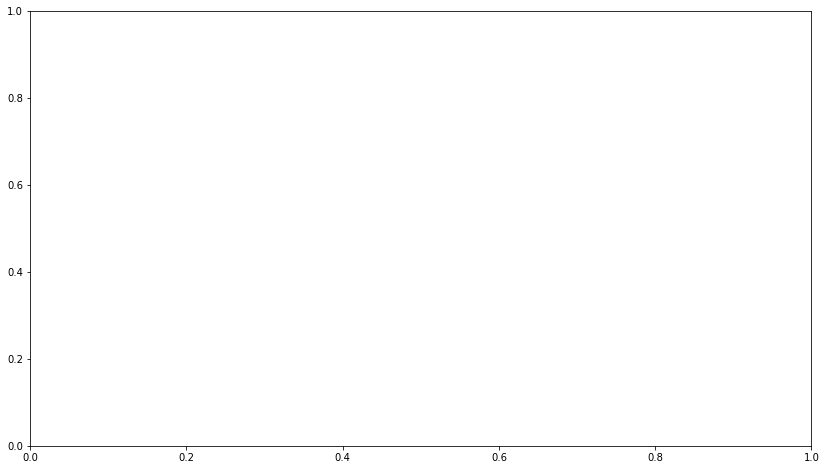

In [12]:
fig = plotCT(image)
fig.savefig('../fig/model0/image_t0')

T = 3
fig = plotCT(X.sel(T = T))
fig.savefig(f'../fig/model0/image_t{T}')

T = X['T'].max().data
fig = plotCT(X.sel(T = T))
fig.savefig(f'../fig/model0/image_t{T}')

In [13]:

def dropna(array1):
    nan_array = np.isnan(array1)
    not_nan_array = ~ nan_array
    array2 = array1[not_nan_array]
    return array2

def cloudFraction(image):
    x = dropna(image.astype(int).where(image > 0).data.flatten()).astype(int)
    return np.bincount(x, minlength = 11) / len(x)#, np.unique(x)

# plt.hist(image.data.flatten(), bins = 11, density = True)
cloudFraction(image), cloudFraction(X)



AttributeError: 'Dataset' object has no attribute 'data'

In [29]:
def sliceImage(image, ibound, jbound):
    
    return  image.sel( i  = slice(image.i[ibound[0]], image.i[ibound[1]]),
                      j = slice(image.j[jbound[0]], image.j[jbound[1]]))


def cloudFractionSD(image, N):
    """
    blocks of NXN
    """

    I = np.arange(len(image.i) // N)
    J = np.arange(len(image.j) // N)

    cfs = np.zeros((len(I), len(J), 11))

    for i, j in itertools.product(I, J):
        ibound = [i * N, (i + 1) * N - 1]
        jbound = [j * N, (j + 1) * N - 1]
        sub_image = sliceImage(image, ibound, jbound )
        
        cfs[i,j,:] = cloudFraction(sub_image)
    return cfs.std(axis = (0,1))
    
    
cloudFractionSD(image, 50), cloudFractionSD(X, 50)


(array([0.        , 0.23484804, 0.07131659, 0.06920008, 0.18486302,
        0.05888512, 0.08344004, 0.05514292, 0.00728358, 0.01273394,
        0.02971479]),
 array([0.        , 0.04790297, 0.01534479, 0.00819413, 0.02880782,
        0.00973482, 0.01584155, 0.01975507, 0.00084962, 0.00312543,
        0.01056824]))

In [53]:
cf = np.array([cloudFraction(X.sel(T = t)) for t in X['T'] ])
sigma_cf = np.array([cloudFractionSD(X.sel(T = t), 32) for t in X['T'] ])

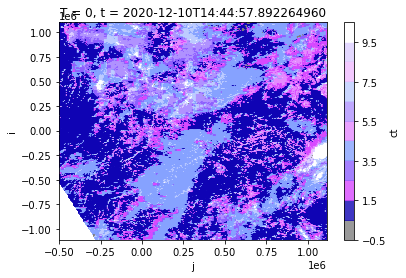

In [50]:
X.sel(T = 0).plot(cmap = cmap , norm = norm)



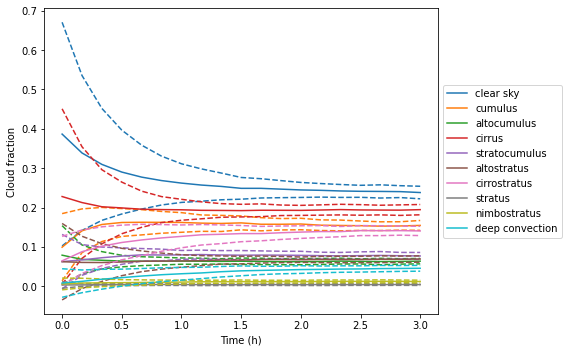

In [75]:
import matplotlib.colors as mcolors
colors =  list(mcolors.TABLEAU_COLORS.values())
names = list(util.ISCCP_classes.values())

t = X['T'] / 6
plt.figure(figsize = (8, 5))
for cloud_type in range(1, 11):
    plt.plot(t, cf[:, cloud_type], label = names[cloud_type], c = colors[cloud_type - 1])
    plt.plot(t, cf[:, cloud_type] + sigma_cf[:, cloud_type], '--', c = colors[cloud_type - 1])
    plt.plot(t, cf[:, cloud_type] - sigma_cf[:, cloud_type], '--', c = colors[cloud_type - 1])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Time (h)')
plt.ylabel('Cloud fraction')
plt.tight_layout()
plt.savefig('../fig/model0/cloud_frac')

# T_total_data.loc['All']

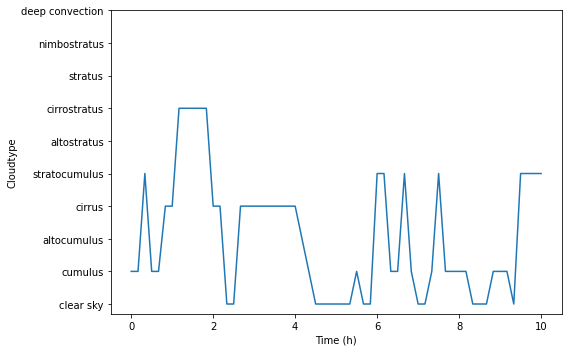

In [74]:
n = 60
t = np.arange(n + 1) / 6 # hours
one_pixel = MC(1, M, n) + 1
plt.figure(figsize = (8, 5))
plt.plot(t, one_pixel)
plt.yticks(levels[1:], labels = list(util.ISCCP_classes.values())[1:])
plt.ylabel('Cloudtype')
plt.xlabel('Time (h)')
plt.tight_layout()
plt.savefig('../fig/model0/one_pixel_path')
plt.show()



In [15]:
X_data =  images.sel(j = slice(-500000)).ct

X_data
cf = np.array([cloudFraction(X_data.sel(t = t)) for t in X_data.t ])
sigma_cf = np.array([cloudFractionSD(X_data.sel(t = t), 32) for t in X_data.t ])

NameError: name 'cloudFractionSD' is not defined

In [14]:

def plotCloudFrac(X, t = None):
    if t == None:
        t = X.t
    fig = plt.figure(figsize = (8, 5))
    for cloud_type in range(1, 11):
        plt.plot(t, cf[:, cloud_type], label = names[cloud_type], c = colors[cloud_type - 1])
        plt.plot(t, cf[:, cloud_type] + sigma_cf[:, cloud_type], '--', c = colors[cloud_type - 1], alpha = .5)
        plt.plot(t, cf[:, cloud_type] - sigma_cf[:, cloud_type], '--', c = colors[cloud_type - 1], alpha = .5)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel('Time (h)')
    plt.ylabel('Cloud fraction')
    plt.tight_layout()
    return fig

plotCloudFrac(X_data)
plt.savefig('../fig/model0/cloud_frac_data')

NameError: name 'X_data' is not defined